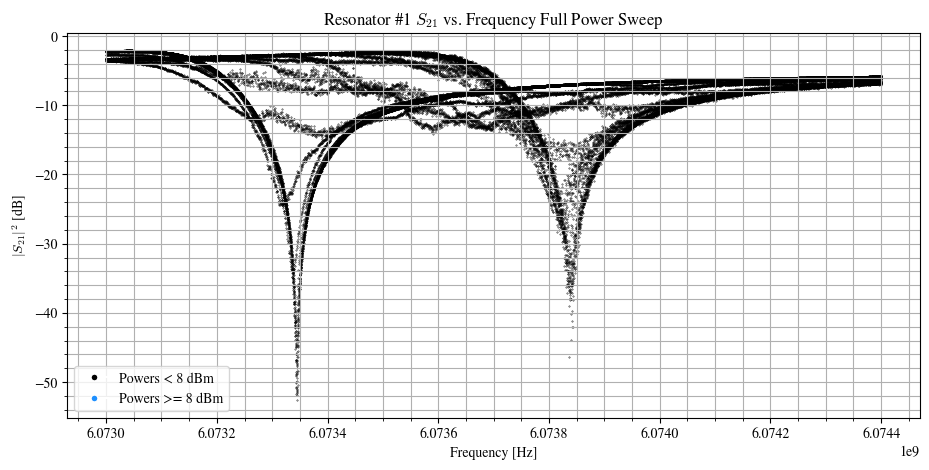

[-60. -57. -54. -51. -48. -45. -42. -39. -36. -33. -30. -27. -24. -21.
 -18. -15. -12.  -9.  -6.  -3.   0.]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.formatter.useoffset'] = False

# Load data
FileName = '2_24_2025_VNA_S21vsPower_transmon1_3200pts_T=10mK'
data = np.loadtxt(FileName, delimiter=',')
Pwrs = data[0, 1:]
fr = data[1:, 0]
S21 = data[1:, 1:]

# Plotting
plt.figure(figsize=[11, 5])

# Define the power level threshold
# Change this to your specific power level
#NOTE: Figure out how to write the program so it finds the non-linearities. Look to FitVsPower below to start
threshold_power = 8

# Track if the labels have been added to avoid duplicates
red_label_added = False
black_label_added = False

# Iterate through each power level and plot accordingly
for idx, power in enumerate(Pwrs):
    if power >= threshold_power:
        color = 'dodgerblue'
        if not red_label_added:
            plt.scatter(fr, S21[:, idx], s=0.1, color=color, label=f'Powers >= {threshold_power}')
            red_label_added = True
        else:
            plt.scatter(fr, S21[:, idx], s=0.1, color=color)
    else:
        color = 'black'
        if not black_label_added:
            plt.scatter(fr, S21[:, idx], s=0.1, color=color, label=f'Powers < {threshold_power}')
            black_label_added = True
        else:
            plt.scatter(fr, S21[:, idx], s=0.1, color=color)

plt.minorticks_on()
plt.grid(which='both')
plt.title('Resonator #1 $S_{21}$ vs. Frequency Full Power Sweep')
plt.xlabel('Frequency [Hz]')
plt.ylabel('$|S_{21}|^2$ [dB]')

# Create custom legend handles with larger markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label=f'Powers < {threshold_power} dBm'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='dodgerblue', markersize=5, label=f'Powers >= {threshold_power} dBm')
]

plt.legend(handles=legend_elements, loc='lower left')
#plt.savefig("Res1 Full Power Sweep", facecolor="w")
plt.show()


print(Pwrs)



----PRE-FIT PARAMETERS ESTIMATION----
IL[dB] = -50.45
f0[Hz] = 6.073344E+09
FWHM [Hz] = 1.751E+03
Qt = 1.654E+04
Qe = 1.662E+04
Qi = 3.469E+06
----FIT RESULTS----
f0[Hz] = 6.073344E+09
Qt = 1.996E+04
Qe = 2.010E+04
Qi = 2.895E+06
A = -3.981E+00
Deltaf = -1.583E+05
----PRE-FIT PARAMETERS ESTIMATION----
IL[dB] = -36.62
f0[Hz] = 6.073837E+09
FWHM [Hz] = 9.628E+03
Qt = 1.669E+04
Qe = 1.714E+04
Qi = 6.309E+05
----FIT RESULTS----
f0[Hz] = 6.073837E+09
Qt = 1.893E+04
Qe = 1.957E+04
Qi = 5.792E+05
A = -3.787E+00
Deltaf = -1.642E+05
Resonant frequency difference f_{shift} = 4.937E+05 Hz


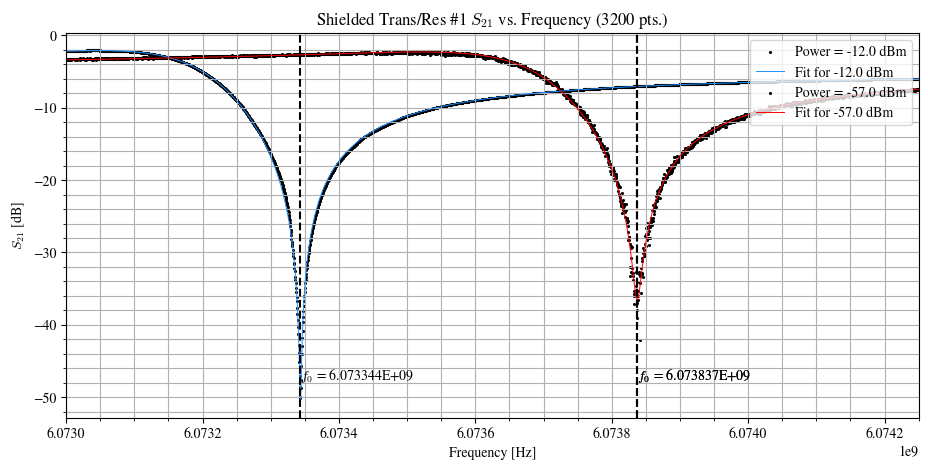

In [7]:
def ResonatorHanger(fr, f0, Qt, Qe, A):
    S21power = (1-Qt/Qe/(1+4*Qt**2*(fr/f0-1)**2))**2 + (2*Qt**2*(fr/f0-1)/Qe/(1+4*Qt**2*(fr/f0-1)**2))**2
    S21power = A + 10*np.log10(S21power)
    return S21power

def ResonatorHangerAsymmetric(fr, f0, Qt, Qe, A, df):
    ResLinear = 1 - (1/Qe - 2*1j*df/f0)/(1/Qt+2*1j*(fr/f0-1))
    S21power = A + 20*np.log10(abs(ResLinear));
    return S21power

def ResonatorHangerAsymmetricQFactors(fr, S21_dB, PwrRange=None, VerboseOutput=True):
    peak = np.min(S21_dB)
    fr_peak = fr[np.argmin(S21_dB)]
    Prefactor = (S21_dB[0] + S21_dB[-1]) / 2

    try:
        # Calculate FWHM
        fr_3dB = 2 * np.abs(fr[np.argmin(np.abs(S21_dB - peak - 3.01))] - fr_peak)
        if fr_3dB == 0:
            raise ValueError("FWHM is zero, skipping this power level.")

        Qi = fr_peak / fr_3dB if fr_3dB != 0 else np.inf  # Prevent divide by zero
    except (ValueError, IndexError) as e:
        print(f"Error in FWHM calculation: {e}")
        return None

    QtOverQe = 1 - 10 ** ((peak - Prefactor) / 20)
    Qe = Qi * (1 / QtOverQe - 1) if QtOverQe != 1 else np.inf
    Qt = (1 / Qe + 1 / Qi) ** -1 if Qe != 0 and Qi != 0 else np.inf

    if VerboseOutput:
        print('----PRE-FIT PARAMETERS ESTIMATION----')
        print(f'IL[dB] = {peak:.2f}')
        print(f'f0[Hz] = {fr_peak:.6E}')
        print(f'FWHM [Hz] = {fr_3dB:.3E}')
        print(f'Qt = {Qt:.3E}')
        print(f'Qe = {Qe:.3E}')
        print(f'Qi = {Qi:.3E}')

    # Windowing
    if PwrRange is None:
        fr_wndw = fr
        S21_wndw = S21_dB
    else:
        peak_idx = np.argmin(S21_dB)
        Idx_width = np.abs(peak_idx - np.argmin(np.abs(S21_dB - Prefactor + PwrRange)))
        fr_wndw = fr[peak_idx - Idx_width:peak_idx + Idx_width]
        S21_wndw = S21_dB[peak_idx - Idx_width:peak_idx + Idx_width]

    # Fitting
    Initial = [fr_peak, Qt, Qe, Prefactor, 0]
    try:
        popt, pcov = curve_fit(ResonatorHangerAsymmetric, fr_wndw, S21_wndw, p0=Initial,
                               bounds=(np.array([0, 0, 0, -np.inf, -np.inf]),
                                       np.array([np.inf, np.inf, np.inf, np.inf, np.inf])))
        f0_fit = popt[0]
        Qt_fit = popt[1]
        Qe_fit = popt[2]
        A_fit = popt[3]
        df_fit = popt[4]
        Qi_fit = (1 / Qt_fit - 1 / Qe_fit) ** -1 if Qt_fit != 0 and Qe_fit != 0 else np.inf

        if VerboseOutput:
            print('----FIT RESULTS----')
            print(f'f0[Hz] = {fr[np.argmin(S21_fit)]:.6E}')
            print(f'Qt = {Qt_fit:.3E}')
            print(f'Qe = {Qe_fit:.3E}')
            print(f'Qi = {Qi_fit:.3E}')
            print(f'A = {A_fit:.3E}')
            print(f'Deltaf = {df_fit:.3E}')
    except Exception as e:
        print(f"Fitting error: {e}")
        return None

    return f0_fit, Qt_fit, Qe_fit, Qi_fit, A_fit, df_fit

# Function to fit the data
def ResonatorHangerAsymmetricFit(fr, S21_dB):
    initial_params = [fr[np.argmin(S21_dB)], 10000, 5000, np.max(S21_dB), 0]
    bounds_lower = [min(fr), 0, 0, -np.inf, -np.inf]
    bounds_upper = [max(fr), np.inf, np.inf, np.inf, np.inf]

    try:
        popt, _ = curve_fit(ResonatorHangerAsymmetric, fr, S21_dB, p0=initial_params, 
                            bounds=(bounds_lower, bounds_upper))
        return popt
    except Exception as e:
        print(f"Fitting error: {e}")
        return None

# Load data
FileName = '2_24_2025_VNA_S21vsPower_transmon1_3200pts_T=10mK'
data = np.loadtxt(FileName, delimiter=',')
Pwrs = data[0, 1:]
fr = data[1:, 0]
S21 = data[1:, 1:]

# Define two power ranges to search within
power_range_1 = (-12, -12)  # Replace with your desired power range 1 (dBm)
power_range_2 = (-57, -57)  # Replace with your desired power range 2 (dBm)

plt.figure(figsize=[11, 5])


f0_fits = []

def find_closest_power_levels(power_range, power_levels, data, fr):
    min_diff = np.inf
    closest_powers = []

    for power_level in power_levels:
        if power_range[0] <= power_level <= power_range[1]:
            idx = np.where(Pwrs == power_level)[0][0]
            min_s21_idx = np.argmin(S21[:, idx])
            min_s21 = S21[min_s21_idx, idx]
            freq_at_min_s21 = fr[min_s21_idx]
            
            if abs(freq_at_min_s21 - np.mean(fr)) < min_diff:
                min_diff = abs(freq_at_min_s21 - np.mean(fr))
                closest_powers = [power_level]
            elif abs(freq_at_min_s21 - np.mean(fr)) == min_diff:
                closest_powers.append(power_level)

    return closest_powers

# Find the closest power levels within the defined ranges
closest_power_1 = find_closest_power_levels(power_range_1, Pwrs, S21, fr)
closest_power_2 = find_closest_power_levels(power_range_2, Pwrs, S21, fr)

all_closest_powers = list(set(closest_power_1 + closest_power_2))

power_color_map = {
    closest_power_1[0]: 'dodgerblue',  # Assign 'black' to the first closest power
    closest_power_2[0]: 'red'     # Assign 'red' to the second closest power
}

for i, power_level in enumerate(all_closest_powers):
    if power_level in Pwrs:
        idx = np.where(Pwrs == power_level)[0][0]
        plt.scatter(fr, S21[:, idx], s=1.5, color='black', label=f'Power = {power_level} dBm')

        # Fit the data for this power level
        popt = ResonatorHangerAsymmetricFit(fr, S21[:, idx])
        if popt is not None:
            S21_fit = ResonatorHangerAsymmetric(fr, *popt)
            f0_fit = fr[np.argmin(S21_fit)]#popt[0]
            f0_fits.append(f0_fit)

            # Use the color mapping for fits
            fit_color = power_color_map.get(power_level, 'blue')  # Default to 'blue' if not mapped
            plt.plot(fr, S21_fit, linewidth=.7, color=fit_color, label=f'Fit for {power_level} dBm')

            ResonatorHangerAsymmetricQFactors(fr, S21_fit, PwrRange = 10, VerboseOutput = True)

            # Draw a vertical line at f0_fit
            for f0 in f0_fits:
                plt.axvline(x=(fr[np.argmin(S21_fit)]), color='black', linestyle='--')
                plt.text((fr[np.argmin(S21_fit)]), plt.ylim()[0] * 0.9, f'$f_0$ = {(fr[np.argmin(S21_fit)]):.6E}', color='black')
                

# Calculate and print the difference between the two resonant frequencies
if len(f0_fits) == 2:
    f_shift = np.abs(f0_fits[0] - f0_fits[1])
    print(f"Resonant frequency difference f_{{shift}} = {f_shift:.3E} Hz")

plt.minorticks_on()
plt.grid(which='both')
plt.title('Shielded Trans/Res #1 $S_{21}$ vs. Frequency (3200 pts.)')
plt.xlabel('Frequency [Hz]')
plt.xlim(6.073e9, 6.07425e9)
plt.ylabel('$S_{21}$ [dB]')

# Add legend
plt.legend(loc='upper right')
plt.savefig('2_25_2025_VNA_S21vsPower_Trans1_T=10mK_3200pts', facecolor='w')
plt.show()

